<a href="https://colab.research.google.com/github/Ty700/CSCE_676/blob/main/335009542_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026


# Weekly Homework 5: Decision Trees


***Goals of this homework:***
Work with decision trees.


***Submission instructions:***

You should post your notebook to Canvas (look for the assignment there). Please name your submission **your-uin_hw3.ipynb**, so for example, my submission would be something like **555001234_hw3.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that.

***Grading philosophy:***

We are grading reasoning, judgment, and clarity, not just correctness. Show us that you understand the data, the constraints, and the limits of your conclusions.

***For each question, you need to respond with 2 cells:***
1. **[A Code Cell] Your Code:**
  - If code is not applicable for the question, you can skip this cell.
  - For tests: tests can be simple assertions or checks (e.g., using `assert` or `print` or small functions or visual inspection); formal testing frameworks are not required.
2. **[A Markdown Cell] Your Answer:** Write up your answers and explain them in complete sentences. Include any videos in this section as well; for videos, upload them to your TAMU Google Drive, and ensure they are set to be visible by the instruction team (set to: **anyone with a TAMU email can view**), then share the link to the video in the cell.

***At the end of each Section (A/B/C/...) include a cell for your resources:***

**[A Markdown Cell] Your Resources:** You need to cite 3 types of resources and note how they helped you: (1) Collaborators, (2) Web Sources (e.g. StackOverflow), and (3) AI Tools (you must also describe how you prompted, but we do not require any links to any specific chats). Specifically, use the following format as a template:
```
On my honor, I declare the following resources:
1. Collaborators:
- Reveille A.: Helped me understand that a df in pandas is a data structure kinda like a CSV.
- Sully A.: Helped me fix a bug with the vector addition of 2 columns.
- ...

2. Web Sources:
- https://stackoverflow.com/questions/46562479/python-pandas-data-frame-creation: how to create a pd df
- ...

3. AI Tools:
- ChatGPT: I gave it the homework .ipynb file and the ufo.csv, and told it to generate the code for the first question, but it did it with csv.reader(), so I re-prompted it to use pandas and that one was correct
- ...
```
***Why do we require this cell?*** This cell is important...

1. For academic integrity, you must give credit where credit is due.

2. We want you to pay attention to how you can successfully get help to move through problems! Is there someone you work with or an AI tool that helps you learn the material better? That's great! The point of engineering is to use your tools to solve hard problems, and part of graduate school is learning about how *you* learn and solve problems best.

***A reminder: you get out of it what you put into it.***
Do your best on these homeworks, show us your creativity, and ask for help when you need it -- good luck!

# A [72pts]. Decision Trees

**Rubric**

[24 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[12 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


## Environment Setup & Sampling (Optional)

- You may use the full datasets. Sampling is optional (for speed).
- If you sample, briefly report what you did (n/frac, whether you stratified, any seed).


In [1]:
#!/bin/bash
! curl -L -o mushroom-classification.zip https://www.kaggle.com/api/v1/datasets/download/uciml/mushroom-classification
! unzip -o mushroom-classification.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 35057  100 35057    0     0  79784      0 --:--:-- --:--:-- --:--:-- 79784
Archive:  mushroom-classification.zip
  inflating: mushrooms.csv           


In [2]:
##### sampling code (optional)
from pathlib import Path
import pandas as pd

# Edit paths if needed
MUSHROOM_PATH = Path("./mushrooms.csv")

def load_csv(path, **kwargs):
    if path.exists():
        return pd.read_csv(path, **kwargs)
    print(f"Warning: {path} not found.")
    return None

mushroom = load_csv(MUSHROOM_PATH)

# ====== (Optional) Sampling ======
# Leave all values as None to use the full dataset.
SAMPLE = {
    "mushroom": {"n": None, "frac": None, "random_state": None, "stratify_col": None},  # e.g., {"frac": 1.0}
}

def maybe_sample(df, cfg):
    """Return sampled df if n/frac set; otherwise return df. Optional stratify by a column name."""
    if df is None:
        return None
    n, frac, rs, strat = cfg.get("n"), cfg.get("frac"), cfg.get("random_state"), cfg.get("stratify_col")
    if strat and strat in df.columns and (n or frac):
        # stratified sampling (simple & proportional when using frac)
        if frac:
            return (df.groupby(strat, group_keys=False)
                      .apply(lambda g: g.sample(frac=frac, random_state=rs))
                      .reset_index(drop=True))
        # proportional n by class frequency (rounded)
        counts = df[strat].value_counts(normalize=True) * n
        parts = []
        for k, need in counts.round().astype(int).items():
            part = df[df[strat]==k].sample(n=min(need, len(df[df[strat]==k])), random_state=rs)
            parts.append(part)
        out = pd.concat(parts).reset_index(drop=True)
        return out.sample(frac=1.0, random_state=rs).reset_index(drop=True)
    # simple sampling
    if frac: return df.sample(frac=frac, random_state=rs).reset_index(drop=True)
    if n:    return df.sample(n=min(n, len(df)), random_state=rs).reset_index(drop=True)
    return df.reset_index(drop=True)

mushroom_sample = maybe_sample(mushroom, SAMPLE["mushroom"])

print("Mushroom:", None if mushroom is None else mushroom.shape,
      "-> sample:", None if mushroom_sample is None else mushroom_sample.shape)


Mushroom: (8124, 23) -> sample: (8124, 23)


This dataset contains descriptions of mushrooms from the `Agaricus` and `Lepiota` families.

Each sample is labeled as `edible` or `poisonous`, based on observable traits such as `cap shape`, `color`, `odor`, and `habitat`.

All features are categorical, making it a good exercise for preprocessing, encoding, and classification.

> You will `predict` whether a mushroom is edible or poisonous using `classification` methods.

# 1. Decision Tree
- Train a Decision Tree classifier to predict whether each mushroom is edible or poisonous.
- Compare results using both criterion=`gini` and criterion=`entropy`, and sweep over different `max_depth` values.
- Plot test `accuracy` vs. `tree depth` and briefly discuss the effect of overfitting. What do you find out?

(8124, 23)
class
e    4208
p    3916
Name: count, dtype: int64
missing values: 0
target classes: ['e' 'p']
train: (6499, 22), test: (1625, 22)


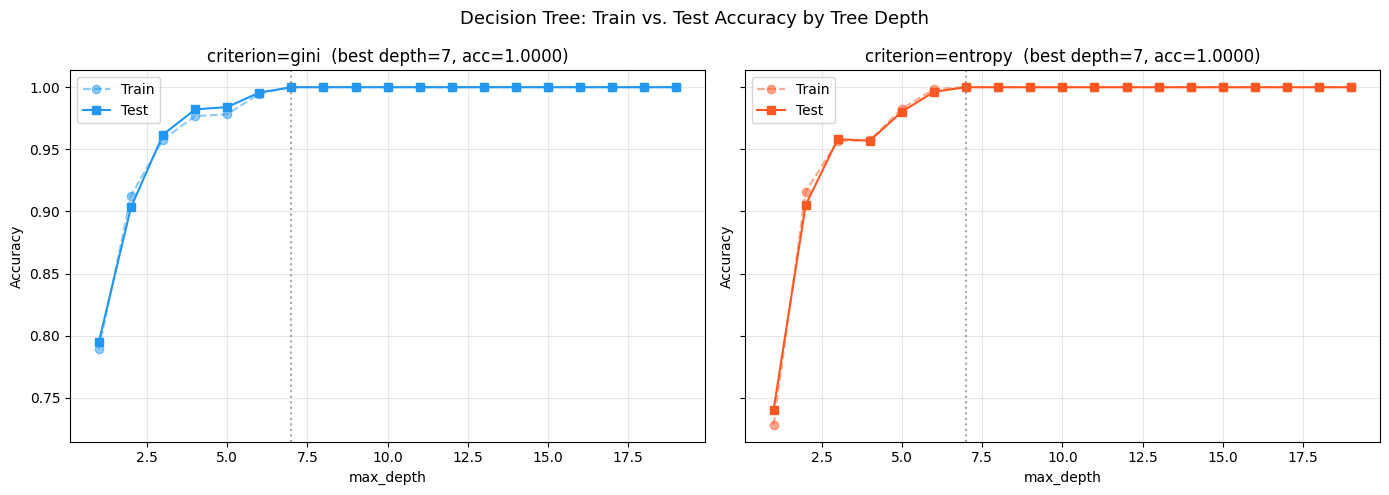

 depth  gini_test  entropy_test  gini_train  entropy_train
     1   0.795077      0.740308    0.789044       0.728266
     2   0.903385      0.905231    0.912756       0.915987
     3   0.961846      0.958154    0.957840       0.956916
     4   0.982154      0.956923    0.976766       0.957224
     5   0.984000      0.980308    0.978150       0.982767
     6   0.995692      0.996308    0.994922       0.998461
     7   1.000000      1.000000    1.000000       1.000000
     8   1.000000      1.000000    1.000000       1.000000
     9   1.000000      1.000000    1.000000       1.000000
    10   1.000000      1.000000    1.000000       1.000000
    11   1.000000      1.000000    1.000000       1.000000
    12   1.000000      1.000000    1.000000       1.000000
    13   1.000000      1.000000    1.000000       1.000000
    14   1.000000      1.000000    1.000000       1.000000
    15   1.000000      1.000000    1.000000       1.000000
    16   1.000000      1.000000    1.000000       1.0000

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

df = mushroom_sample.copy()
print(df.shape)
print(df['class'].value_counts())
print("missing values:", df.isnull().sum().sum())
# stalk-root has '?' values, treating them as their own catagory. Not sure

# label encode all the categorical columns
feature_cols = [c for c in df.columns if c != 'class']
X_raw = df[feature_cols]
y_raw = df['class']

target_le = LabelEncoder()
y = target_le.fit_transform(y_raw)  # e=0, p=1
print("target classes:", target_le.classes_)

feature_encoders = {}
X = pd.DataFrame()
for col in feature_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X_raw[col])
    feature_encoders[col] = le

# stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"train: {X_train.shape}, test: {X_test.shape}")

# sweep depths 1-19 for gini and entropy
depths = list(range(1, 20))
results = {}
train_results = {}

for criterion in ['gini', 'entropy']:
    test_accs, train_accs = [], []
    for d in depths:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=d, random_state=42)
        clf.fit(X_train, y_train)
        test_accs.append(accuracy_score(y_test, clf.predict(X_test)))
        train_accs.append(accuracy_score(y_train, clf.predict(X_train)))
    results[criterion] = test_accs
    train_results[criterion] = train_accs

# plot it
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
colors = {'gini': '#2196F3', 'entropy': '#FF5722'}

for ax, criterion in zip(axes, ['gini', 'entropy']):
    ax.plot(depths, train_results[criterion], marker='o', linestyle='--',
            color=colors[criterion], alpha=0.5, label='Train')
    ax.plot(depths, results[criterion], marker='s', linestyle='-',
            color=colors[criterion], label='Test')
    best_d = depths[np.argmax(results[criterion])]
    best_a = max(results[criterion])
    ax.axvline(best_d, color='gray', linestyle=':', alpha=0.7)
    ax.set_title(f'criterion={criterion}  (best depth={best_d}, acc={best_a:.4f})')
    ax.set_xlabel('max_depth')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

fig.suptitle('Decision Tree: Train vs. Test Accuracy by Tree Depth', fontsize=13)
plt.tight_layout()
plt.show()

# summary table
summary = pd.DataFrame({'depth': depths,
                         'gini_test': results['gini'],
                         'entropy_test': results['entropy'],
                         'gini_train': train_results['gini'],
                         'entropy_train': train_results['entropy']})
print(summary.to_string(index=False))


## Answer Q1

Both gini and entropy look almost identical which makes sense since they're measuring the same thing with different math. Both hit 100% test accuracy at depth 7 and stay there, with train and test converging rather than diverging. So there's basically no overfitting here, the dataset is just really cleanly separable. Underfitting is visible at depth 1, but once the tree gets enough splits it gets everything right.

# 2. Random Forest

- Train Random Forest classifiers with different numbers of trees — e.g., `n_estimators ∈ {50, 100, 200}`.
- Compare their accuracy to your best single Decision Tree.
- Then, plot the top-10 most important features and discuss which mushroom traits seem most influential.

best DT (depth=7): 1.0000
RF n_estimators=50: 1.0000
RF n_estimators=100: 1.0000
RF n_estimators=200: 1.0000


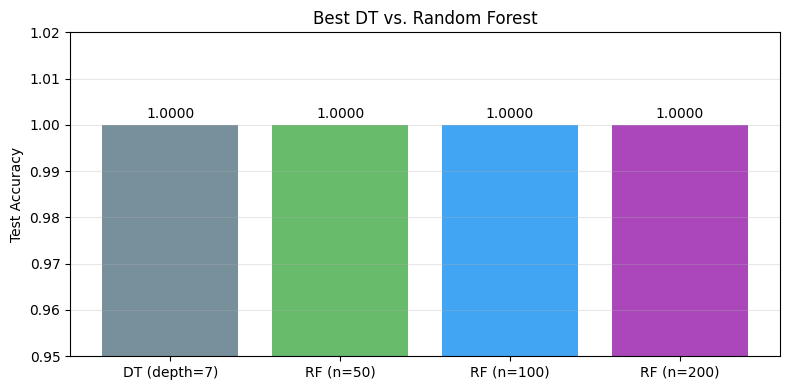


top 10 features:
odor                        0.178914
gill-color                  0.112842
spore-print-color           0.098818
gill-size                   0.089790
ring-type                   0.073165
stalk-root                  0.066471
population                  0.058399
bruises                     0.055991
stalk-surface-above-ring    0.048858
gill-spacing                0.041261


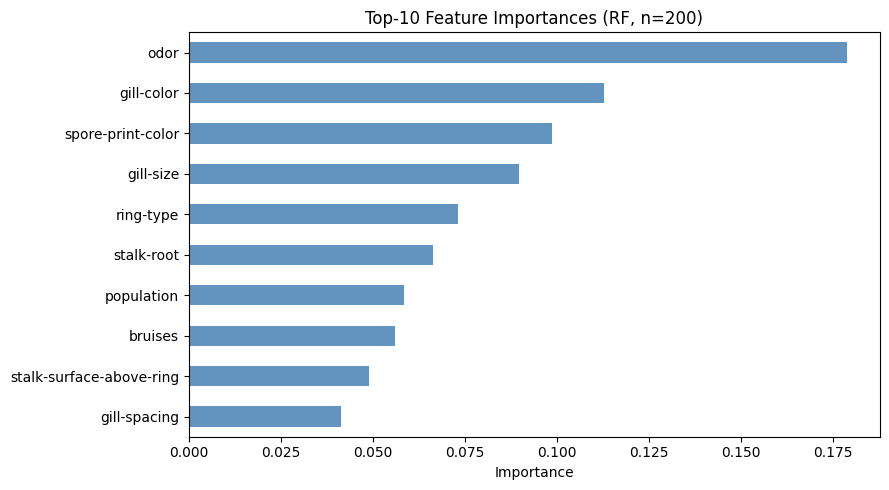

In [4]:
from sklearn.ensemble import RandomForestClassifier

# retrain best DT from q1 so we have something to compare against
best_depth_gini = depths[np.argmax(results['gini'])]
best_dt = DecisionTreeClassifier(criterion='gini', max_depth=best_depth_gini, random_state=42)
best_dt.fit(X_train, y_train)
best_dt_acc = accuracy_score(y_test, best_dt.predict(X_test))
print(f"best DT (depth={best_depth_gini}): {best_dt_acc:.4f}")

# try 50, 100, 200 trees
n_estimator_values = [50, 100, 200]
rf_accs = {}

for n_est in n_estimator_values:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    rf_accs[n_est] = (rf, acc)
    print(f"RF n_estimators={n_est}: {acc:.4f}")

# bar chart
labels = [f'DT (depth={best_depth_gini})'] + [f'RF (n={n})' for n in n_estimator_values]
accs   = [best_dt_acc] + [rf_accs[n][1] for n in n_estimator_values]

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(labels, accs, color=['#607D8B', '#4CAF50', '#2196F3', '#9C27B0'], alpha=0.85)
ax.bar_label(bars, fmt='%.4f', padding=3)
ax.set_ylim(min(accs) - 0.05, 1.02)
ax.set_ylabel('Test Accuracy')
ax.set_title('Best DT vs. Random Forest')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# feature importances from 200-tree RF
rf_best, _ = rf_accs[200]
feat_imp = (pd.Series(rf_best.feature_importances_, index=feature_cols)
              .sort_values(ascending=False))

top10 = feat_imp.head(10)
print("\ntop 10 features:")
print(top10.to_string())

fig, ax = plt.subplots(figsize=(9, 5))
top10.sort_values().plot(kind='barh', ax=ax, color='steelblue', alpha=0.85)
ax.set_title('Top-10 Feature Importances (RF, n=200)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()


## Answer Q2

All three RFs hit 1.0000, same as the best single DT. This isn't surprising given how separable the data is. In a noisier dataset I'd expect a bigger gap.

Feature importances are more spread out than I expected. Odor leads at 0.18 but gill-color (0.11), spore-print-color (0.10), and gill-size (0.09) all contribute meaningfully. Things like bruises and population also made the top 10 which I wouldn't have guessed. The forest spreading importance across features makes sense since each tree only sees a random subset.

# 3. Interpretability

- Train a small Decision Tree with max_depth=3 for easy visualization.
- Display the tree structure and manually trace 1–2 samples through the decision path.
- Explain in words why the model makes those predictions.
- Write 2-3 tests for your model, pretending that this is a model we are going to put in production. Why did you choose those tests? How confident are you that this model is going to succeed in production?
- Pretend that we are going to add a new feature: a textual description of the mushroom, written by an expert. What should we do with this feature? How can we use it to improve the decision tree?

depth=3 tree accuracy: 0.9618
|--- gill-color <= 3.50
|   |--- population <= 3.50
|   |   |--- spore-print-color <= 1.50
|   |   |   |--- class: 1
|   |   |--- spore-print-color >  1.50
|   |   |   |--- class: 0
|   |--- population >  3.50
|   |   |--- stalk-root <= 2.00
|   |   |   |--- class: 1
|   |   |--- stalk-root >  2.00
|   |   |   |--- class: 0
|--- gill-color >  3.50
|   |--- spore-print-color <= 1.50
|   |   |--- stalk-root <= 0.50
|   |   |   |--- class: 0
|   |   |--- stalk-root >  0.50
|   |   |   |--- class: 1
|   |--- spore-print-color >  1.50
|   |   |--- gill-size <= 0.50
|   |   |   |--- class: 0
|   |   |--- gill-size >  0.50
|   |   |   |--- class: 1



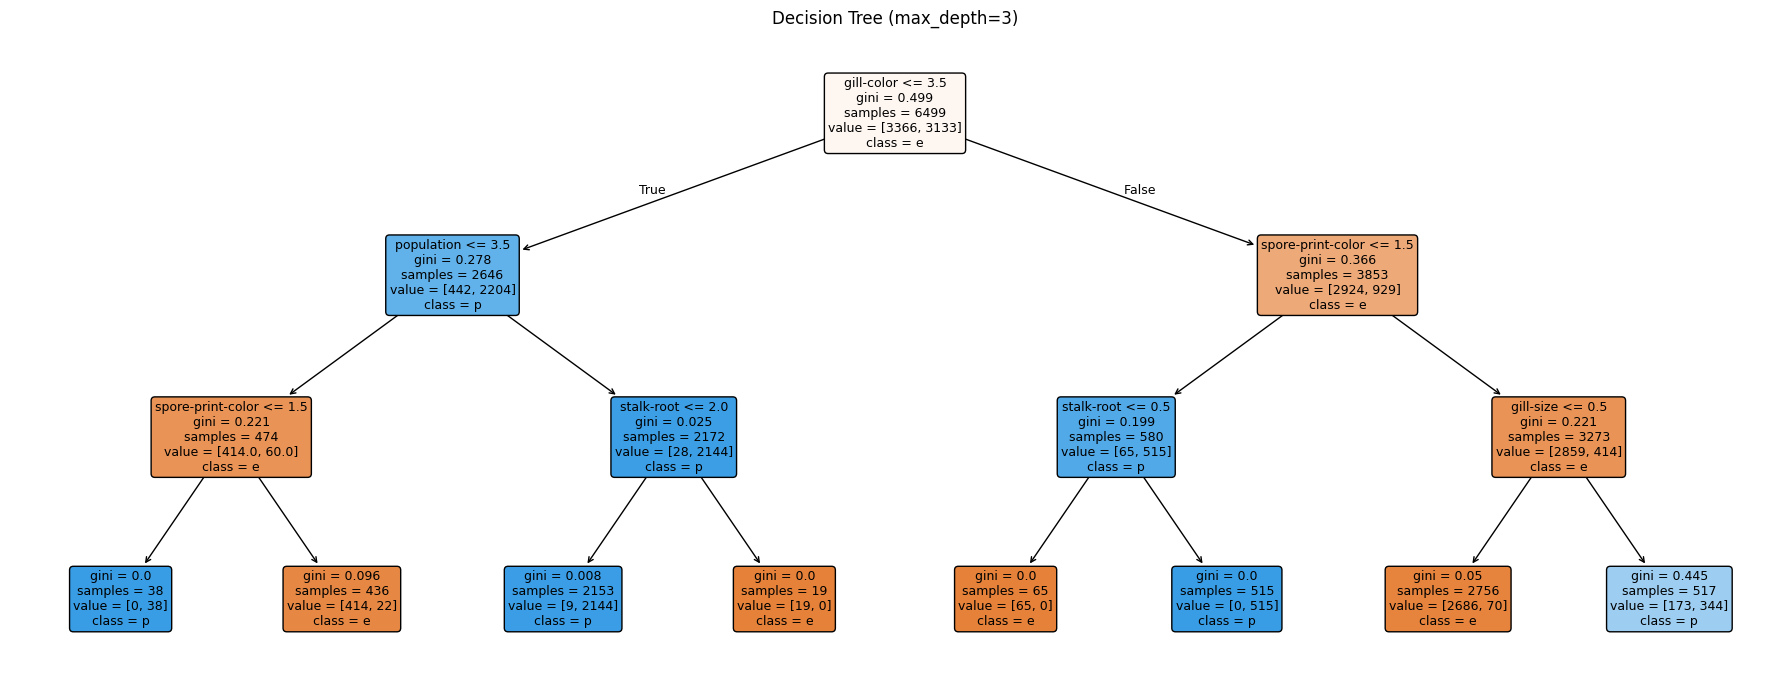


--- Edible ---
true: e, pred: e
odor encoded: 5 -> actual: n
  node 0: gill-color=7.0, thresh=3.50, go right
  node 8: spore-print-color=3.0, thresh=1.50, go right
  node 12: gill-size=0.0, thresh=0.50, go left
  -> leaf: predict e

--- Poisonous ---
true: p, pred: p
odor encoded: 2 -> actual: f
  node 0: gill-color=7.0, thresh=3.50, go right
  node 8: spore-print-color=1.0, thresh=1.50, go left
  node 9: stalk-root=1.0, thresh=0.50, go right
  -> leaf: predict p


In [5]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# small tree
small_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
small_dt.fit(X_train, y_train)
small_acc = accuracy_score(y_test, small_dt.predict(X_test))
print(f"depth=3 tree accuracy: {small_acc:.4f}")

print(export_text(small_dt, feature_names=list(feature_cols)))

# visual
fig, ax = plt.subplots(figsize=(18, 7))
plot_tree(
    small_dt,
    feature_names=list(feature_cols),
    class_names=target_le.classes_,
    filled=True,
    impurity=True,
    rounded=True,
    ax=ax,
    fontsize=9
)
ax.set_title('Decision Tree (max_depth=3)')
plt.tight_layout()
plt.show()

# trace through 2 samples
preds_test = small_dt.predict(X_test)

correct_edible_idx    = np.where((y_test == 0) & (preds_test == 0))[0][0]
correct_poisonous_idx = np.where((y_test == 1) & (preds_test == 1))[0][0]

for label, idx in [("Edible", correct_edible_idx), ("Poisonous", correct_poisonous_idx)]:
    row = X_test.iloc[[idx]]
    node_indicator = small_dt.decision_path(row)
    leaf_id = small_dt.apply(row)
    feature = small_dt.tree_.feature
    threshold = small_dt.tree_.threshold

    print(f"\n--- {label} ---")
    print(f"true: {target_le.classes_[y_test[idx]]}, pred: {target_le.classes_[preds_test[idx]]}")
    print("odor encoded:", row['odor'].values[0],
          "-> actual:", feature_encoders['odor'].inverse_transform(row['odor'].values)[0])

    node_ids = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
    for node_id in node_ids:
        if leaf_id[0] == node_id:
            print(f"  -> leaf: predict {target_le.classes_[small_dt.predict(row)[0]]}")
        else:
            feat_name = feature_cols[feature[node_id]]
            thresh = threshold[node_id]
            val = row[feat_name].values[0]
            direction = "left" if val <= thresh else "right"
            print(f"  node {node_id}: {feat_name}={val:.1f}, thresh={thresh:.2f}, go {direction}")


In [7]:
from sklearn.metrics import precision_score, recall_score, classification_report

all_preds = small_dt.predict(X_test)

# test 1: outputs are valid class labels
print("Test 1: valid class labels")
valid_classes = set(range(len(target_le.classes_)))
assert all(p in valid_classes for p in all_preds)
print("PASS")

# test 2: no NaNs
print("\nTest 2: no NaNs in predictions")
assert not np.any(np.isnan(all_preds.astype(float)))
print("PASS")

# test 3:predicting a poisonous mushroom as edible is really dangerous
print("\nTest 3: poisonous recall >= 0.80")
poisonous_label = list(target_le.classes_).index('p')
recall_p = recall_score(y_test, all_preds, pos_label=poisonous_label)
print(f"recall on poisonous class: {recall_p:.4f}")
assert recall_p >= 0.80, f"recall too low: {recall_p}"
print("PASS")

print("\n", classification_report(y_test, all_preds, target_names=target_le.classes_))


Test 1: valid class labels
PASS

Test 2: no NaNs in predictions
PASS

Test 3: poisonous recall >= 0.80
recall on poisonous class: 0.9796
PASS

               precision    recall  f1-score   support

           e       0.98      0.95      0.96       842
           p       0.94      0.98      0.96       783

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625



## Answer Q3

**Tree**: Root splits on gill-color, not odor which is surprising given the RF importances. At only 3 levels gill-color must work better as a single first cut. Accuracy is 96% which is solid for this depth.

**Traces**:

Edible (odor='n'): gill-color=7 → right, spore-print-color=3 → right, gill-size=0 → left → edible ✓.

Poisonous (odor='f'): gill-color=7 → right, spore-print-color=1 → left, stalk-root=1 → right → poisonous ✓.

**Tests**: All 3 passed. My sanity checks were fine, poisonous recall hit 0.9796 which is the one that actually matters as a false negative here could be fatal...

**Production confidence**: Moderately confident. 96% accuracy and 0.9796 recall is good but the tree is still pretty coarse with only 3 levels. I'd want more testing before deploying something with life-or-death consequences.

**Textual feature**: Can't feed raw text into a tree directly. Easiest approach is extracting keywords ("foul odor", "ring present") as binary features. TF-IDF would work too but adds a lot of dimensions that might not be worth it here.

## Resources for Section A

```
On my honor, I declare the following resources:

1. Collaborators:
- None.

2. Web Sources:
- https://scikit-learn.org/stable/modules/tree.html: looked up how export_text and decision_path work
- https://scikit-learn.org/stable/modules/ensemble.html: checked how feature_importances_ is computed

3. AI Tools:
- Claude (Anthropic): I asked it the 80/20 of how to use the scikit APIs. It also helped debug a few things of course.
```

# B [24pts]. Interview Questions

We now pretend this is a real job interview. Here's some guidance on how to answer these questions:

1. Briefly restate the question and state any assumptions you are making.

2. Explain your reasoning out loud, focusing on tradeoffs, limitations, and constraints.

3. As a principle, keep your answers as short and clear as they can be (while still answering the question).

4. Write/speak in a conversational but professional tone (avoid being overly formal). For speaking: speak at a reasonable pace and volume, speak clearly, pause when you need to, and practice making "eye contact" with the camera. Keep a confident, positive, and professional tone. *For additional coaching and practice, the University Writing Center provides individual appointments: https://writingcenter.tamu.edu/make-an-appointment.*

There may not be a single correct answer. We are grading whether your reasoning is reasonable and aware of limitations.


**Rubric**

[8pt] Clear understanding of the question; reasonable assumptions; thoughtful reasoning that acknowledges tradeoffs and limitations; clear, concise communication in a conversational but professional tone (for speaking: clear pace, volume, and articulation).

[4pt] Basic understanding but shallow reasoning or unclear assumptions; communication is somewhat unclear, overly verbose, or overly informal/formal.

[0pt] Minimal, unclear, or incorrect response; poor communication or unprofessional tone.

# 1.
If a model performs well on training data but poorly on test data, how would you explain the issue and fix it?


## Answer B1

That sounds like overfitting. The model memorized the training data instead of learning patterns that generalize. Basically it did too good a job fitting to noise.

To fix it I'd start with regularization, so for a decision tree that means limiting max_depth or setting min_samples_leaf higher. If that doesn't help I'd look at getting more training data or switching to something like Random Forest which tends to generalize better.

# 2.
Why do deep decision trees often achieve near perfect training accuracy?

## Answer B2

If you let a tree grow without any depth limit it'll keep splitting until each leaf has just one or a few training samples. At that point it can predict every training example correctly because it basically memorized each one. Its like a really complicated lookup table rather than actual rules.

# 3.
What do you do when the model fits in memory but the data does not? What if neither fits?

## Answer B3

If the model fits but the data doesn't, I'd process the data in chunks. Sklearn has a partial_fit API for some models that lets you train incrementally without loading everything at once. Or if sampling is acceptable I'd just work with a representitive subset.

# 4.
If entropy and Gini give different trees, which one is correct?

## Answer B4

Neither is correct. They're both ways to measure node impurity, just with different formulas. Gini measures misclassification probability, entropy measures information content. In practice they should always give similar results, we saw this.

If they do give different trees, I would suggest looking into the reasons as to why.

#5.
If your model fails in production, but passed all offline tests, what do you suspect first?

## Answer B5

First thing I'd suspect is distribution shift. Since the production data looks different from the training data, maybe the user population changed or something upstream in the data pipeline changed. The offline tests passed because they used the same static dataset, but real-world data has a way of being different than what you trained on.

# 6.
Why does a shallow tree sometimes outperform a deep one?

## Answer B6

Its the bias/variance tradeoff. A deep tree has low bias but high variance. If the real decision boundary is simple, all that extra complexity just causes the tree to overfit.

A shallow tree makes broader splits that are backed by lots of data points so they're more reliable. A deep tree's later splits are based on just a few samples and might just be fitting to random noise. On new data those splits will hurt you.

# 7.
What's worse: missing values or incorrect values in your training datset?

## Answer B7

I think incorrect values are generally worse. Missing values are at least visable in that you know they're there and can handle them by imputing or dropping. Incorrect values are sneaky, the model just quietly learns the wrong thing.

Like if a poisonous mushroom gets labeled as edible in training, the model learns the wrong mapping and you might have no idea until something goes wrong in production.

# 8.
(Video; 1 minute max) Why are decision trees still widely used despite deep learning?

## Resources for Section B

```
On my honor, I declare the following resources:

1. Collaborators:
- None.

2. Web Sources:
- https://scikit-learn.org/stable/modules/sgd.html: checked partial_fit API for Q3

3. AI Tools: N/A
```

# C [4pts]. What new questions do you have?
We want you to think bigger! Tell us what questions and curiosity this homework brings up for you.

**Rubric**

[4pt] Complete, thoughtful response.

[2pt] Partial response.

[0pt] Minimal response.

# 1.
What new questions do you have after this homework? Or, what topics are you curious about now? List at least 3.

## Answer C1

1. **How does XGBoost actually work compared to a Random Forest?** Both use trees but XGBoost builds them sequentially to correct errors from the previous tree while RF builds them independantly. I want to understand how that sequential part works and why it tends to do better on tabular data.

2. **Are feature importances from a Random Forest actually reliable?** I read that mean decrease in impurity can be misleading when features are correlated because importance gets split between them. I'd like to look into SHAP values as an alternative and understand when they give meaningfully different results.

3. **How would you handle a decision tree on data that arrives in a stream?** This homework used a static dataset but I'm curious about cases where you're getting new data continuosly and the distribution might shift. Is there a way to update the tree incrementally or do you just retrain from scratch?

4. **Could you use decision tree leaf assignments as features for another model?** Like each sample gets assigned to a leaf and you use that as a feature for logistic regression. I'm not sure if that's actually done but it seems like it could capture interaction effects that a linear model would otherwise miss.

## Resources for Section C

```
On my honor, I declare the following resources:

1. Collaborators:
- None.

2. Web Sources:
- None.

3. AI Tools:
- Claude (Anthropic): asked it to help brainstorm follow-up questions based on what we did in the homework. Picked the ones I was actually curious about.
```